In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import time
from pathlib import Path


def load_image(image_path, transform):
    img = Image.open(image_path).convert('L')
    return transform(img)

def create_embedding_dicts(data_root, model, device='mps'):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    modalities = ['periocular']
    splits = ['test']
    train_dict = {}
    test_dict = {}

    model = model.to(device)
    model.eval()

    for split in splits:
        print("Doing: ", split)
        target_dict = train_dict if split == 'train' else test_dict
        # Get person IDs from directory
        person_ids = [f"{i:03d}" for i in range(1, 248)]
        for person_id in person_ids:
            print("Person ", person_id)
            target_dict[person_id] = []  # List to store 10 embeddings
            # Iterate over poses (1 to 10)
            for pose_idx in range(1, 11):
                # Load images for all three modalities for this person and pose
                images = []
                for modality in modalities:
                    img_path = Path(data_root) / modality / split / person_id
                    pose_images = [f for f in sorted(os.listdir(img_path)) if f!='.DS_Store']
                    if len(pose_images) < pose_idx:
                        print(f"Warning: {img_path} has only {len(pose_images)} poses, expected at least {pose_idx}")
                        break
                    img_name = pose_images[pose_idx - 1]  # Select the pose_idx-th image
                    img_path = img_path / img_name
                    if not img_path.exists():
                        print(f"Warning: {img_path} does not exist")
                        break
                    img = load_image(img_path, transform).to(device)
                    images.append(img)
                else:  # Only execute if all images are found
                    # Pass three images to the model
                    zero_vector = torch.zeros(1, 128, 128).unsqueeze(0).to(device)
                    with torch.no_grad():
                        embedding = model(
                            images[0].unsqueeze(0),  # periocular (add batch dim)
                            zero_vector,  # forehead
                            zero_vector   # iris
                        ).squeeze(0).cpu()  # Remove batch dim
                    target_dict[person_id].append(embedding)
                if len(images) != 3:  # Skip if any image was missing
                    continue

    return train_dict, test_dict

In [20]:
data_root = './dataset2'

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

# from cvpr.MFA_ViT import MFA_ViT
# model = MFA_ViT(
#     img_size=128,           # Match the image size in your transform
#     patch_size=8,           # Standard patch size
#     in_chans=1,             # 1 channel for grayscale images
#     embed_dim=64,         # Embedding dimension
#     layer_depth=4,          # Standard transformer depth
#     num_heads=8,            # Number of attention heads
#     prompt_mode="deep",     # Using deep prompts
#     prompt_tokens=32,       # Number of prompt tokens
#     embedding_size=128      # Final embedding dimension for InfoNCE
# ).to(device)

# state_dict = torch.load('./cvpr/best_model.pt')
# model.load_state_dict(state_dict)
# model.eval()

from cnn_transformer.model_mpt import BiometricModel
model = BiometricModel(embedding_dim=256)
state_dict = torch.load('./cnn_transformer/model_latest_mpt_best.pt')
model.load_state_dict(state_dict)
model.eval()


train_dict, test_dict = create_embedding_dicts(data_root, model, device)

Doing:  test
Person  001
Person  002
Person  003
Person  004
Person  005
Person  006
Person  007
Person  008
Person  009
Person  010
Person  011
Person  012
Person  013
Person  014
Person  015
Person  016
Person  017
Person  018
Person  019
Person  020
Person  021
Person  022
Person  023
Person  024
Person  025
Person  026
Person  027
Person  028
Person  029
Person  030
Person  031
Person  032
Person  033
Person  034
Person  035
Person  036
Person  037
Person  038
Person  039
Person  040
Person  041
Person  042
Person  043
Person  044
Person  045
Person  046
Person  047
Person  048
Person  049
Person  050
Person  051
Person  052
Person  053
Person  054
Person  055
Person  056
Person  057
Person  058
Person  059
Person  060
Person  061
Person  062
Person  063
Person  064
Person  065
Person  066
Person  067
Person  068
Person  069
Person  070
Person  071
Person  072
Person  073
Person  074
Person  075
Person  076
Person  077
Person  078
Person  079
Person  080
Person  081
Person  082
Per

In [28]:
def evaluate_rank_k(test_dict, gallery_size=5, k=1, device='cuda'):
    """
    Evaluate rank-k recognition accuracy using cosine similarity.
    
    Args:
        test_dict: Dictionary with person IDs as keys and lists of embeddings as values
        gallery_size: Number of poses to use as gallery (remaining used as probe)
        k: The rank-k accuracy to compute (e.g., k=1 for rank-1, k=5 for rank-5)
        device: Device to perform calculations on
    
    Returns:
        Rank-k recognition rate
    """
    correct = 0
    total = 0
    
    # Convert embeddings to tensors and prepare gallery and probe sets
    gallery_embeddings = []
    gallery_labels = []
    probe_embeddings = []
    probe_labels = []
    
    for person_id, embeddings in test_dict.items():
        if len(embeddings) < gallery_size + 1:
            print(f"Skipping person {person_id} with only {len(embeddings)} embeddings")
            continue
            
        # Use first gallery_size embeddings as gallery
        for i in range(gallery_size):
            gallery_embeddings.append(embeddings[i])
            gallery_labels.append(person_id)
            
        # Use remaining embeddings as probe
        for i in range(gallery_size, len(embeddings)):
            probe_embeddings.append(embeddings[i])
            probe_labels.append(person_id)
    
    gallery_tensor = torch.stack(gallery_embeddings).to(device)
    probe_tensor = torch.stack(probe_embeddings).to(device)
    
    # Normalize embeddings for cosine similarity
    gallery_tensor = F.normalize(gallery_tensor, p=2, dim=1)
    probe_tensor = F.normalize(probe_tensor, p=2, dim=1)
    
    print(f"Gallery size: {len(gallery_tensor)} embeddings")
    print(f"Probe size: {len(probe_tensor)} embeddings")
    
    # Calculate similarities in batches to avoid OOM
    batch_size = 100
    correct = 0
    total = len(probe_tensor)
    
    with torch.no_grad():
        for i in tqdm(range(0, len(probe_tensor), batch_size)):
            batch_end = min(i + batch_size, len(probe_tensor))
            batch_probe = probe_tensor[i:batch_end]
            
            # Calculate cosine similarity between probe and gallery
            similarities = torch.mm(batch_probe, gallery_tensor.t())
            
            # Get the indices of top-k highest similarities
            _, indices = torch.topk(similarities, k=k, dim=1)
            
            # Check if the correct match is in top-k predictions
            for j in range(len(batch_probe)):
                probe_person = probe_labels[i + j]
                predicted_persons = [gallery_labels[idx.item()] for idx in indices[j]]
                
                if probe_person in predicted_persons:
                    correct += 1
    
    # Calculate rank-k recognition rate
    rank_k_rate = correct / total if total > 0 else 0
    return rank_k_rate, correct, total

# Add this code after loading the model and creating embeddings
print("Evaluating rank-k recognition performance...")

# Test with different gallery sizes and ranks
gallery_sizes = [5, 8]
ranks = [1, 2, 5]

for gallery_size in gallery_sizes:
    for k in ranks:
        rank_k_rate, c, t = evaluate_rank_k(test_dict, gallery_size=gallery_size, k=k, device=device)
        print(f"Rank-{k} recognition rate with gallery size {gallery_size}: {rank_k_rate:.4f} ({rank_k_rate*100:.2f}%) {c}/{t}")


Evaluating rank-k recognition performance...
Skipping person 212 with only 4 embeddings
Gallery size: 1230 embeddings
Probe size: 1228 embeddings


100%|█████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 385.20it/s]

Rank-1 recognition rate with gallery size 5: 0.4780 (47.80%) 587/1228


Calculating distances...


100%|████████████████████████████████████████████████████████████████| 247/247 [00:25<00:00,  9.60it/s]


Calculating EER...
Equal Error Rate (EER): 0.2115
EER Threshold: 0.2796
TPR at 100% FPR: 0.0074
TPR at 10.0% FPR: 0.9934
TPR at 1.0% FPR: 1.0000


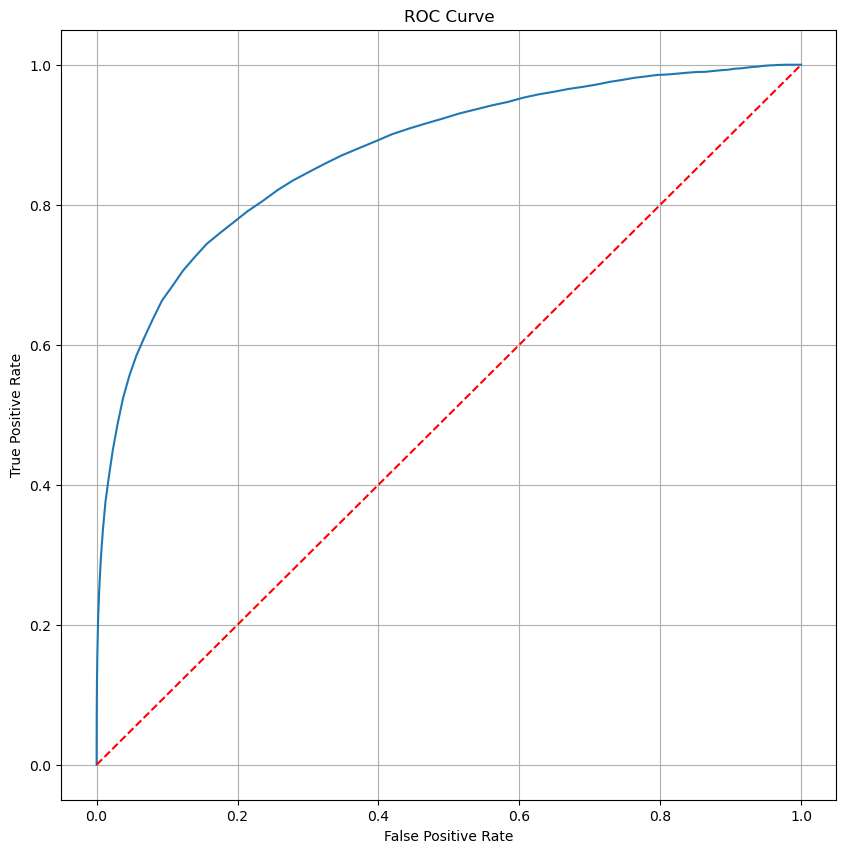

In [29]:
def calculate_distances(test_dict):
    """Calculate genuine and impostor distances."""
    genuine_distances = []
    impostor_distances = []
    
    # Get all person IDs
    person_ids = list(test_dict.keys())
    
    # Calculate distances
    for i, person1 in enumerate(tqdm(person_ids)):
        embeddings1 = test_dict[person1]
        
        # Calculate genuine distances (same person, different poses)
        for j in range(len(embeddings1)):
            for k in range(j + 1, len(embeddings1)):
                dist = F.pairwise_distance(
                    embeddings1[j].unsqueeze(0),
                    embeddings1[k].unsqueeze(0)
                ).item()
                genuine_distances.append(dist)
        
        # Calculate impostor distances (different persons)
        for person2 in person_ids[i + 1:]:
            embeddings2 = test_dict[person2]
            for emb1 in embeddings1:
                for emb2 in embeddings2:
                    dist = F.pairwise_distance(
                        emb1.unsqueeze(0),
                        emb2.unsqueeze(0)
                    ).item()
                    impostor_distances.append(dist)
    
    return np.array(genuine_distances), np.array(impostor_distances)

def calculate_tpr_fpr(genuine_distances, impostor_distances, threshold):
    """Calculate TPR and FPR at a given threshold."""
    genuine_accepts = np.sum(genuine_distances <= threshold)
    impostor_accepts = np.sum(impostor_distances <= threshold)
    
    tpr = genuine_accepts / len(genuine_distances)
    fpr = impostor_accepts / len(impostor_distances)
    
    return tpr, fpr

def calculate_eer(genuine_distances, impostor_distances):
    """Calculate the Equal Error Rate."""
    thresholds = np.linspace(0, max(np.max(genuine_distances), np.max(impostor_distances)), 1000)
    min_diff = float('inf')
    eer = 0
    eer_threshold = 0
    
    for threshold in thresholds:
        tpr, fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
        diff = abs(1 - tpr - fpr)
        
        if diff < min_diff:
            min_diff = diff
            eer = (1 - tpr + fpr) / 2
            eer_threshold = threshold
    
    return eer, eer_threshold

# Evaluate the model
print("Calculating distances...")
genuine_distances, impostor_distances = calculate_distances(test_dict)

print("Calculating EER...")
eer, eer_threshold = calculate_eer(genuine_distances, impostor_distances)
print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

# Calculate TPR at different FPR points
fpr_points = [1, 0.1, 0.01]  # 1%, 0.1%, 0.01%
thresholds = np.sort(impostor_distances)
for target_fpr in fpr_points:
    threshold_idx = int((1 - target_fpr) * len(impostor_distances))
    threshold = thresholds[threshold_idx]
    tpr, actual_fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
    print(f"TPR at {target_fpr*100}% FPR: {tpr:.4f}")

# Plot ROC curve
thresholds = np.linspace(0, max(np.max(genuine_distances), np.max(impostor_distances)), 100)
tpr_list = []
fpr_list = []

for threshold in thresholds:
    tpr, fpr = calculate_tpr_fpr(genuine_distances, impostor_distances, threshold)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr_list, tpr_list)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()
plt.close()


In [30]:
len(genuine_distances)

11041

Computing t-SNE projection...
t-SNE visualization saved as 'embeddings_tsne.png'


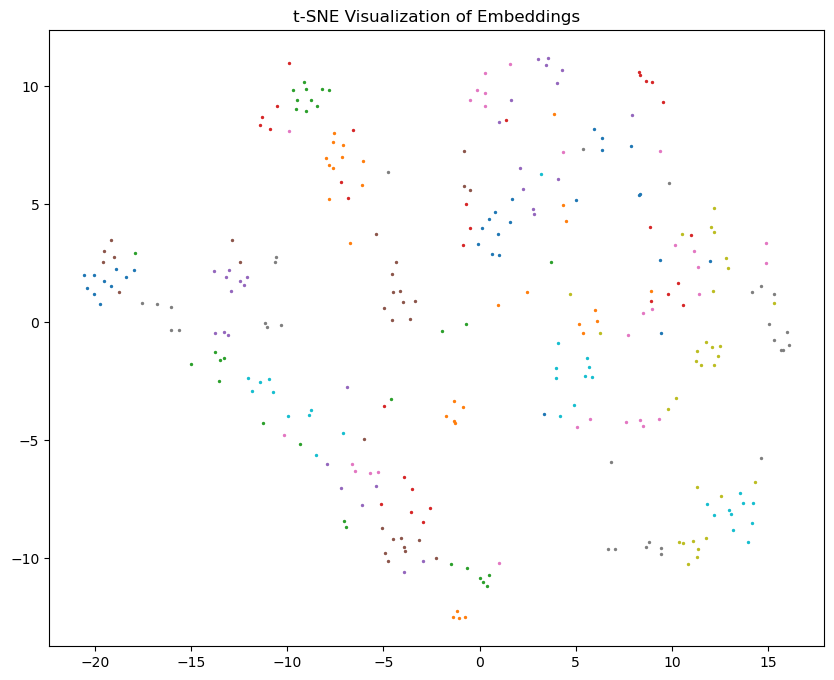

In [24]:
def visualize_embeddings(test_dict, num_persons=30):
    # Collect embeddings and labels
    embeddings = []
    labels = []
    
    # Take first 30 persons
    for i, (person_id, person_embeddings) in enumerate(test_dict.items()):
        if i >= num_persons:
            break
        embeddings.extend(person_embeddings)
        labels.extend([i] * len(person_embeddings))
    
    # Convert to numpy arrays
    embeddings_np = torch.stack(embeddings).numpy()
    
    # Apply t-SNE
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings_np)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_persons):
        indices = [j for j, label in enumerate(labels) if label == i]
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], label=f"Person {i+1}", s=2)
    
    plt.title("t-SNE Visualization of Embeddings")
    plt.savefig("embeddings_tsne.png")
    print("t-SNE visualization saved as 'embeddings_tsne.png'")

# Uncomment to visualize embeddings
visualize_embeddings(test_dict)